# Выбор локации для скважины

**Цель работы** — определить регион, в котором нефтедобыча будет наиболее прибыльной и наименее рискованной.

**Задачи исследования**:

1) Создать модель, способную прогнозировать количество нефти, находящейся в скважинах.

2) На основе результатов моделирования выбрать регион, в котором добыча нефти будет наиболее выгодной и безопасной.

**План исследования**:

1. **Загрузка данных и подготовка данных** 
    * Загрузить данные и провести предобработку данных. 
    * Провести исследовательский анализ всех признак и сделать вывод о том как их подготовить к моделированию. 
    * Провести корреляционный анализ всех таблиц. 
    * Подготовить пайплайны для модели.
    
    
2. **Обучение и проверка модели**
    * Разделить данные на обучающие и валидационные выборки. 
    * Обучить модели на основании данных. 
    * Расчитать средние предсказываемые значения запасов нефти в регионе. Расчитать метрику RMSE.
    
    
3. **Подготовка к расчету прибыли**
    
    * Рассчитать среднее значение запаса нефти в регионе, для того, чтобы добыча нефти приносила прибыль
    
    
4. **Расчет прибыли и рисков**
    * Написать функцию вычисления прибыли.
    * На основании написанной функции и техники Bootstrap получить распределение прибыли в регионах. 
    * Выбрать регион с наибольшей средней прибылью и вероятностью убытков не более 2.5 %
    

5. **Общий вывод**

## Загрузка и подготовка данных

### Загрузка данных

Установим необходимые пакеты

In [125]:
!pip install phik -q
!pip install -U scikit-learn -q

Импортируем необходимые библиотеки

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.dummy import DummyRegressor
from scipy import stats as st

Загрузим датасет с данными о месторождении под номером 0.

In [127]:
df_0 = pd.read_csv('data/geo_data_0.csv')
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Выведем общую ингформацию о датасете

In [128]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Загрузим датасет под номером 1.

In [129]:
df_1 = pd.read_csv('data/geo_data_1.csv')
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Выведем общую информацию о датасете

In [130]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Загрузим датасет с данными о регионе под номером 2.

In [131]:
df_2 = pd.read_csv('data/geo_data_2.csv')
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [132]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Вывод**: Данные корректно загружены

### Предобработка данных

**Найдём скважены в таблицах с повторяющимися индексами**

Найдём дубликаты объёкты с дублирующимися индексами для первой таблицы

In [133]:
dup_0 = df_0[df_0['id'].duplicated()]['id']
dup_1 = df_1[df_1['id'].duplicated()]['id']
dup_2 = df_2[df_2['id'].duplicated()]['id']

print(f'В таблице 0: {df_0["id"].duplicated().sum()} строк с повторяющимися id')
print(f'В таблице 1: {df_1["id"].duplicated().sum()} строки с повторяющимися id')
print(f'В таблице 2: {df_2["id"].duplicated().sum()} строки с повторяющимися id')

В таблице 0: 10 строк с повторяющимися id
В таблице 1: 4 строки с повторяющимися id
В таблице 2: 4 строки с повторяющимися id


Выведем все строки с повторяющимися id

In [134]:
print('\nТаблица 0')
display(df_0.query('id in @dup_0'))
print('\nТаблица 1')
display(df_1.query('id in @dup_1'))
print('\nТаблица 2')
display(df_2.query('id in @dup_2'))


Таблица 0


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205



Таблица 1


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044



Таблица 2


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Скорее всего повторяющиеся данные, находящиеся в начале таблицы устарели. Удалим их и оставим только более поздние наблюдения.

In [135]:
print(f'Количество строк в таблице 0 {df_0.drop(df_0[df_0["id"].duplicated(keep="last")].index).shape[0]}')
print(f'Количество строк в таблице 1 {df_1.drop(df_1[df_1["id"].duplicated(keep="last")].index).shape[0]}')
print(f'Количество строк в таблице 2 {df_2.drop(df_2[df_2["id"].duplicated(keep="last")].index).shape[0]}')

Количество строк в таблице 0 99990
Количество строк в таблице 1 99996
Количество строк в таблице 2 99996


Объекты с повторяющимися индексами были удалены.

**Установка индексов таблиц**

Установим в качестве индексов таблицы, столбец с названием 'id'

In [136]:
df_0 = df_0.set_index('id')
df_0.head(1)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.22117,105.280062


In [137]:
df_1 = df_1.set_index('id')
df_1.head(1)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276,-0.005876,3.179103


In [138]:
df_2 = df_2.set_index('id')
df_2.head(1)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673


**Поиск дубликатов и пропусков**

Посчитаем количество пропусков в таблицах

In [139]:
df_0.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [140]:
df_1.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [141]:
df_2.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

В таблицах отсутствуют пропуски

Посчитаем количество дубликатов в таблицах

In [142]:
df_0.duplicated().sum()

0

In [143]:
df_1.duplicated().sum()

0

In [144]:
df_2.duplicated().sum()

0

В таблицах отсутствуют дубликаты

**Вывод** Данные были предобработаны. Были устранены дубликаты индексов

### Исследовательский анализ данных

**Исследовательский анализ для региона 0**

Все признаки в таблицах являются количественными. Исследуем их распределение с помощью гистограмм

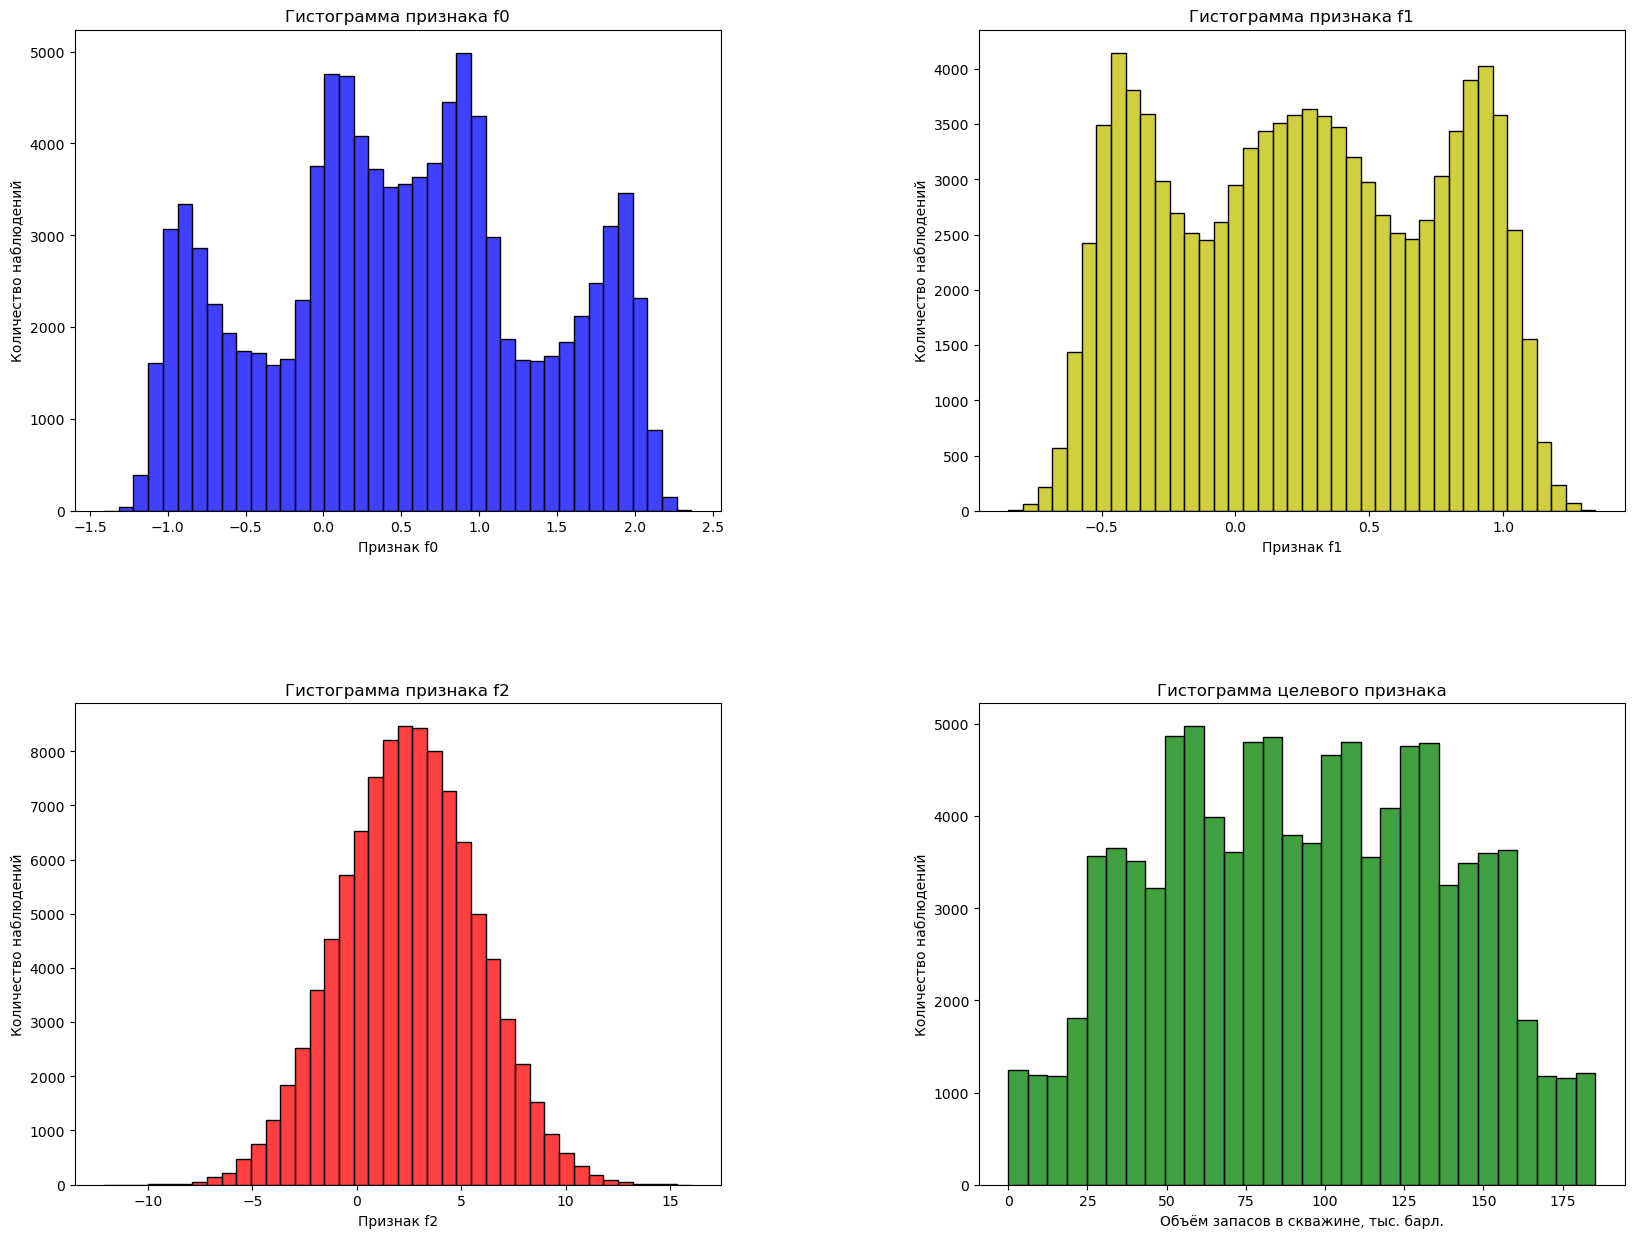

In [145]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.histplot(df_0['f0'],bins=40,ax=ax[0,0],color='b')
ax[0,0].set_xlabel('Признак f0')
ax[0,0].set_ylabel('Количество наблюдений')
ax[0,0].set_title('Гистограмма признака f0')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_0['f1'],bins=40,ax=ax[0,1],color='y')
ax[0,1].set_xlabel('Признак f1')
ax[0,1].set_ylabel('Количество наблюдений')
ax[0,1].set_title('Гистограмма признака f1')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_0['f2'],bins=40,ax=ax[1,0],color='r')
ax[1,0].set_xlabel('Признак f2')
ax[1,0].set_ylabel('Количество наблюдений')
ax[1,0].set_title('Гистограмма признака f2')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_0['product'],bins=30,ax=ax[1,1],color='g')
ax[1,1].set_xlabel('Объём запасов в скважине, тыс. барл.')
ax[1,1].set_ylabel('Количество наблюдений')
ax[1,1].set_title('Гистограмма целевого признака')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

1. Распределние признака f0 - мультимодальное имеет четыре четко выраженных пика, требуется масштабирование
1. Распределние признака f1 - мультимодальное имеет три четко выраженных пика, требуется масштабирование
1. Распределние признака f2 - унимодальное похожее на нормальное, требуется масштабирование
1. Распределние целевого признака - мультимодальное имеет множество выраженных пиков

Исследуем матрицу корреляции

In [146]:
interval_cols = ['f0','f1','f2','product']

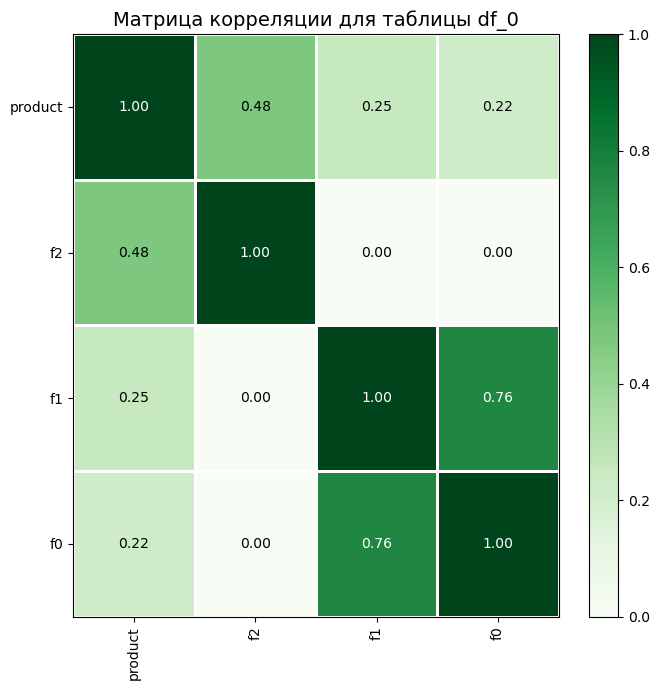

In [147]:
phik_overview = phik_matrix(df_0,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'Матрица корреляции для таблицы df_0',
                        fontsize_factor=1, figsize=(7, 7))

Между признаками f0 и f1 наблюдается сильная корреляция. Однако значения коеффициента корреляции недостаточно, для того чтобы это негативно сказывалось на расчетах. Оставим признаки без изменений.

**Исследовательский анализ для региона 1**

Все признаки в таблицах являются количественными. Исследуем их распределение с помощью гистограмм

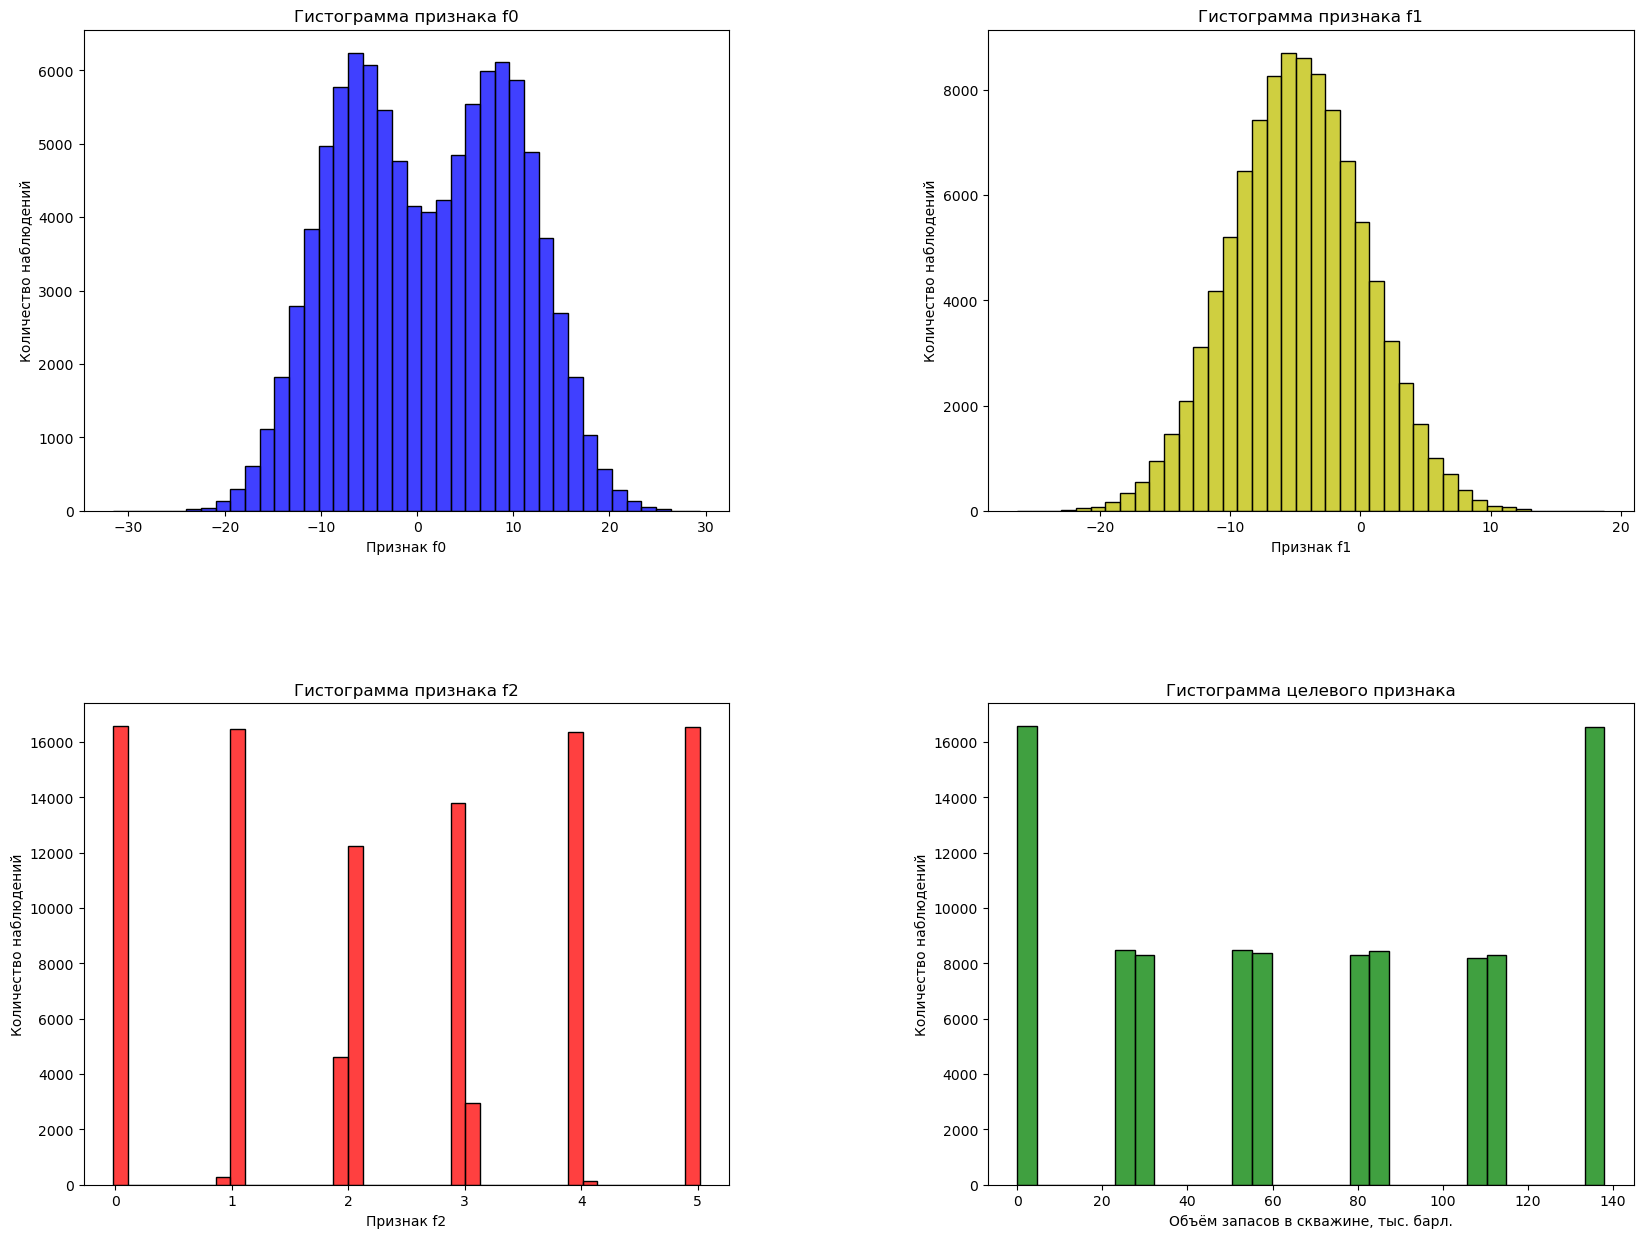

In [148]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.histplot(df_1['f0'],bins=40,ax=ax[0,0],color='b')
ax[0,0].set_xlabel('Признак f0')
ax[0,0].set_ylabel('Количество наблюдений')
ax[0,0].set_title('Гистограмма признака f0')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_1['f1'],bins=40,ax=ax[0,1],color='y')
ax[0,1].set_xlabel('Признак f1')
ax[0,1].set_ylabel('Количество наблюдений')
ax[0,1].set_title('Гистограмма признака f1')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_1['f2'],bins=40,ax=ax[1,0],color='r')
ax[1,0].set_xlabel('Признак f2')
ax[1,0].set_ylabel('Количество наблюдений')
ax[1,0].set_title('Гистограмма признака f2')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_1['product'],bins=30,ax=ax[1,1],color='g')
ax[1,1].set_xlabel('Объём запасов в скважине, тыс. барл.')
ax[1,1].set_ylabel('Количество наблюдений')
ax[1,1].set_title('Гистограмма целевого признака')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

1. Распределние признака f0 - бимодальное, требуется масштабирование
1. Распределние признака f1 - унимодальное похожее на нормальное, требуется масштабирование
1. Распределние признака f2 - представляет собой дискретное распределение
1. Распределние целевого признака - дискретное распределение

Исследуем матрицу корреляции

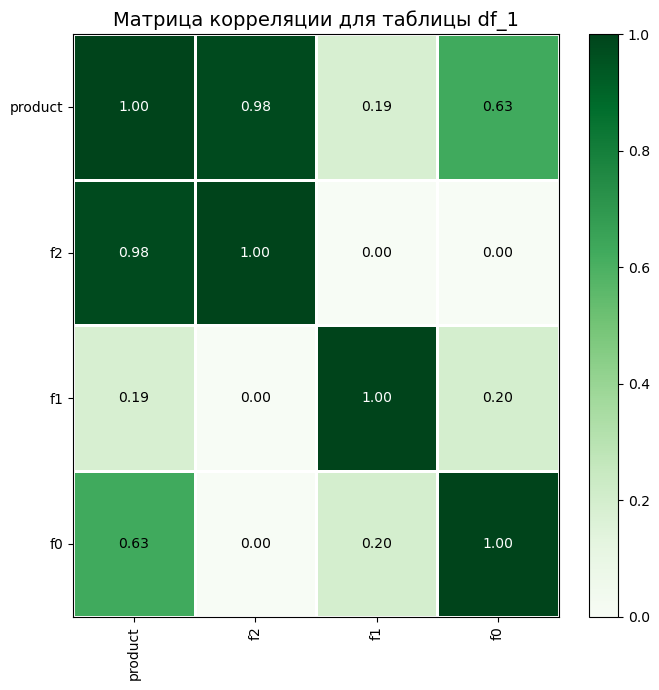

In [149]:
phik_overview = phik_matrix(df_1,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'Матрица корреляции для таблицы df_1',
                        fontsize_factor=1, figsize=(7, 7))

Анализ матрицы корреляции не выявил мультиколлинеарность. Признак f2 демонстрирует сильную корреляцию с целевым признаком.

**Исследовательский анализ для региона 2**

Все признаки в таблицах являются количественными. Исследуем их распределение с помощью гистограмм

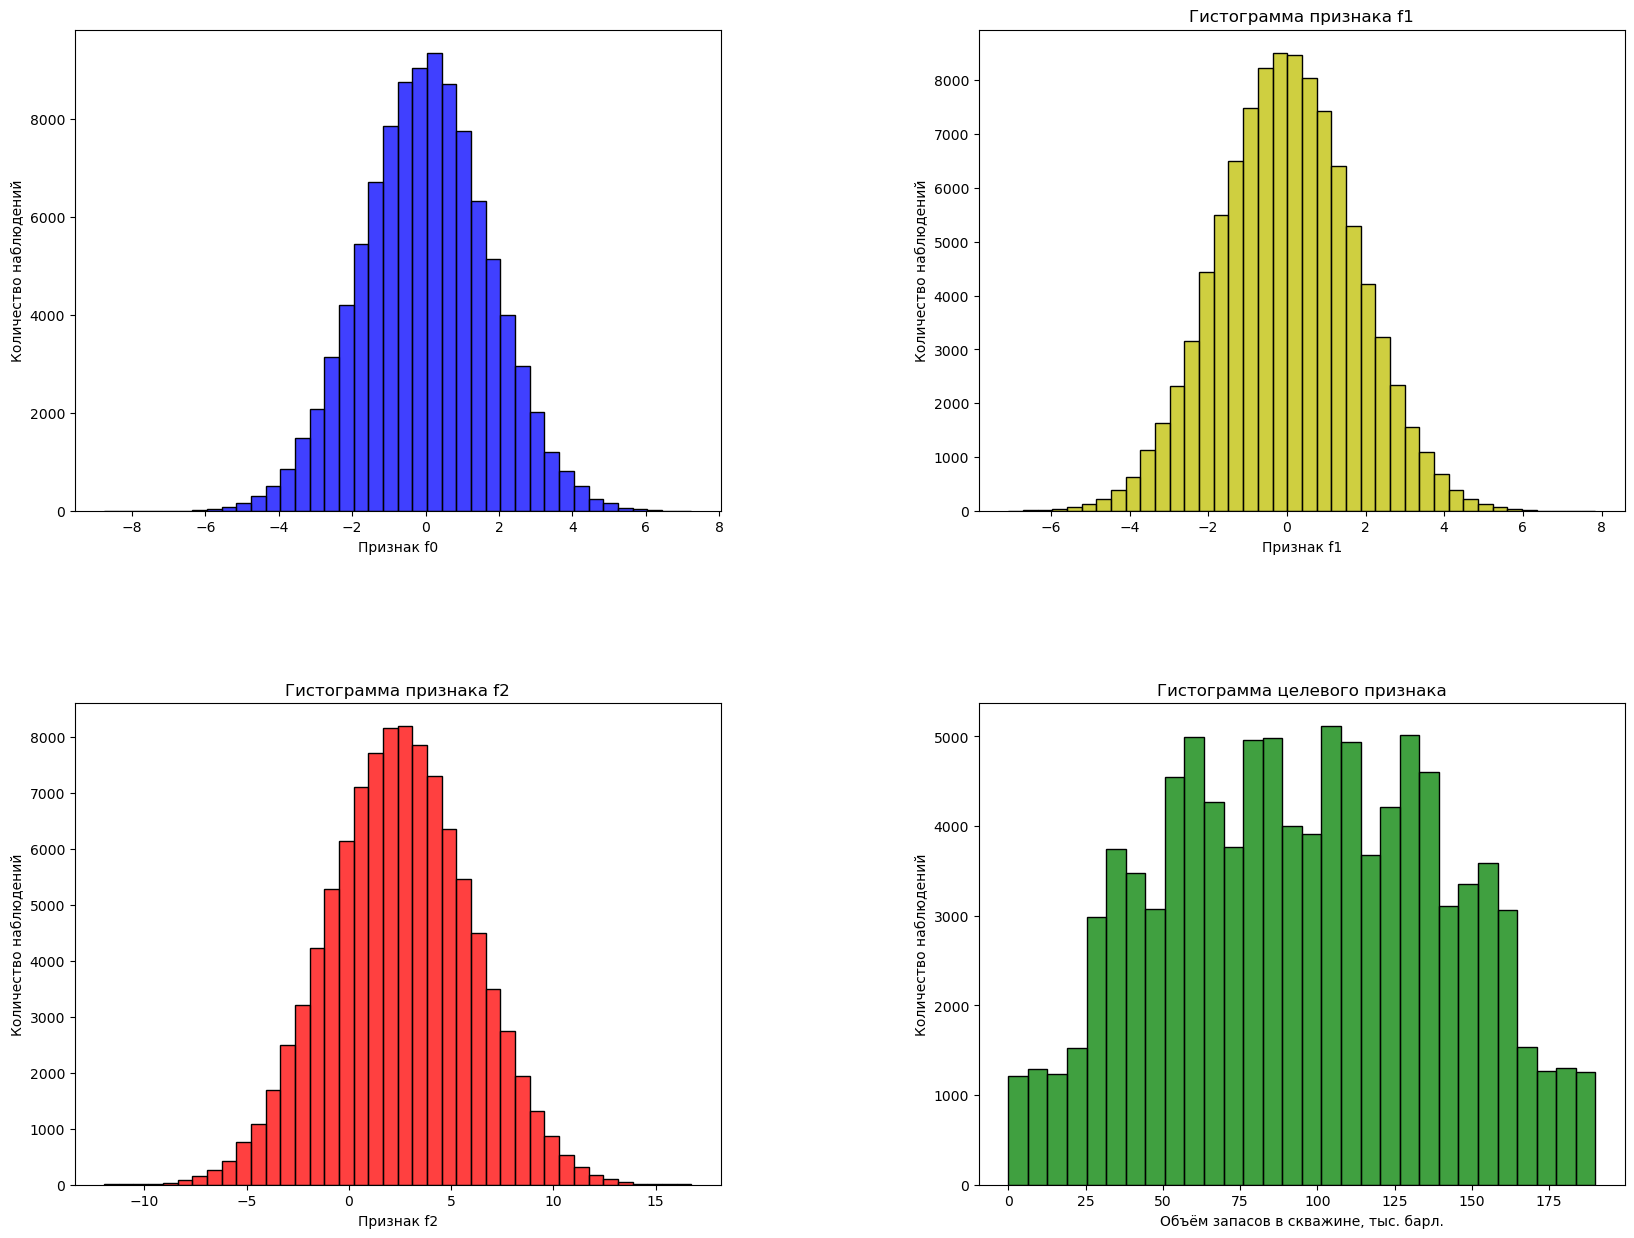

In [150]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.histplot(df_2['f0'],bins=40,ax=ax[0,0],color='b')
ax[0,0].set_xlabel('Признак f0')
ax[0,0].set_ylabel('Количество наблюдений')
ax[1,1].set_title('Гистограмма признака f0')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_2['f1'],bins=40,ax=ax[0,1],color='y')
ax[0,1].set_xlabel('Признак f1')
ax[0,1].set_ylabel('Количество наблюдений')
ax[0
   ,1].set_title('Гистограмма признака f1')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_2['f2'],bins=40,ax=ax[1,0],color='r')
ax[1,0].set_xlabel('Признак f2')
ax[1,0].set_ylabel('Количество наблюдений')
ax[1,0].set_title('Гистограмма признака f2')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.histplot(df_2['product'],bins=30,ax=ax[1,1],color='g')
ax[1,1].set_xlabel('Объём запасов в скважине, тыс. барл.')
ax[1,1].set_ylabel('Количество наблюдений')
ax[1,1].set_title('Гистограмма целевого признака')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

1. Распределние признака f0 - унимодальное похожее на нормальное, требуется масштабирование
1. Распределние признака f1 - унимодальное похожее на нормальное, требуется масштабирование
1. Распределние признака f2 - унимодальное похожее на нормальное, требуется масштабирование
1. Распределние целевого признака - мультимодальное имеет множдество выраженных пиков

Исследуем матрицу корреляции

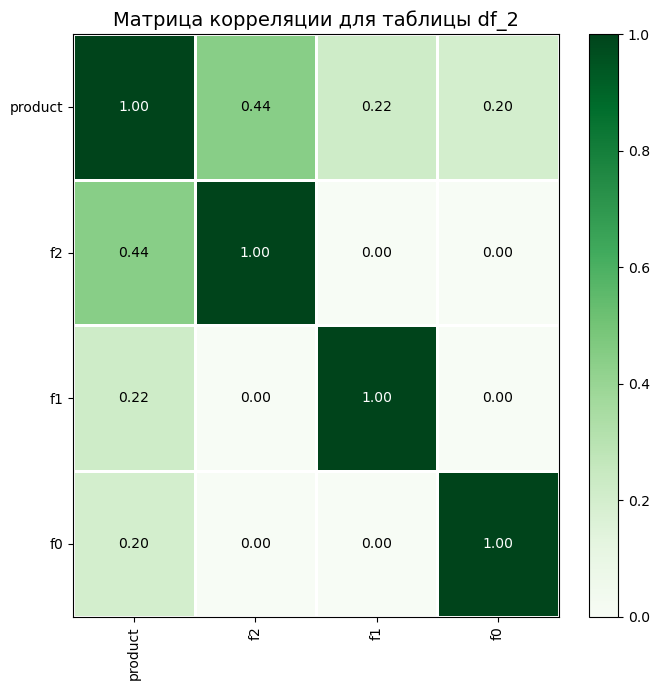

In [151]:
phik_overview = phik_matrix(df_2,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'Матрица корреляции для таблицы df_2',
                        fontsize_factor=1, figsize=(7, 7))

Исследовав матрицу корреляции, можно сделать вывод об отсутствии мультиколлинеарности.

**Вывод**: Был проведен исследовательский и корреляционный анализ признаков таблиц. В ходе анализа не было выявлено никаких выбросов или мультиколлинеарности. 

### Подготовка пайплайна

Подготовим пайплайн для работы с таблицами для регионов 0,1,2

In [152]:
num_columns = ['f0','f1','f2']

Создадим пайплайн для масштабирования признаков в таблицах 0,1,2

In [153]:
data_preprocessor = ColumnTransformer([ ('num', StandardScaler(), num_columns)], 
                                      remainder='passthrough' )

Создадим пайплайн состоящий из предобработки и обучения модели линейной регрессии для работы с данными таблицы 0 

In [154]:
pipe = Pipeline([ ('preprocessor', data_preprocessor),
                        ('model', LinearRegression())])

**Вывод**: Были подготовлены пайплайны для работы с данными

### Вывод по разделу

В разделе по подготовки данных были проделаны следующие шаги

* Данные были загружены и предобработаны. Дубликатов и пропусков не было найдено
* Был проведен исследовательский и корреляционный анализ признаков таблиц. В ходе анализа не было выявлено никаких выбросов или мультиколлинеарности.
* Были подготовлены пайплайны для дальнейшего моделирования

## Обучение и проверка модели

### Формирование выборок

Выделим из выборок целевой признак

In [155]:
y_0 = df_0['product']
X_0 = df_0.drop(columns=['product'])
y_1 = df_1['product']
X_1 = df_1.drop(columns=['product'])
y_2 = df_2['product']
X_2 = df_2.drop(columns=['product'])

Разобьём датасеты на тренировочные и валидационные выборки

In [156]:
X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(X_0, y_0, test_size=0.25, random_state=42)
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(X_1, y_1, test_size=0.25, random_state=42)
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

Данные были разбиты в требуемом отношении

### Обучение модели

Напишем функцию для обучения модели и подсчета метрики

In [157]:
def model_results(X_train, X_valid, y_train, y_valid ):
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(f'Значение метрики RMSE на валидационной выборке {round(root_mean_squared_error(y_valid, y_pred),2)}')
    print(f'Среднее предсказанное значение {round(y_pred.mean(),2)}')
    return y_pred

Обучим модель линейной регрессии для нулевого региона

In [158]:
print('РЕГИОН 0')
y_0_pred = model_results(X_0_train, X_0_valid, y_0_train, y_0_valid)

РЕГИОН 0
Значение метрики RMSE на валидационной выборке 37.76
Среднее предсказанное значение 92.4


In [159]:
print('РЕГИОН 1')
y_1_pred = model_results(X_1_train, X_1_valid, y_1_train, y_1_valid)

РЕГИОН 1
Значение метрики RMSE на валидационной выборке 0.89
Среднее предсказанное значение 68.71


In [160]:
print('РЕГИОН 2')
y_2_pred = model_results(X_2_train, X_2_valid, y_2_train, y_2_valid)

РЕГИОН 2
Значение метрики RMSE на валидационной выборке 40.15
Среднее предсказанное значение 94.77


**Вывод**

Полученные значение для нулевого региона:

   * Значение метрики RMSE на валидационной выборке 37.76
   * Среднее предсказанное значение 92.4

Полученные значения для первого региона:

   * Значение метрики RMSE на валидационной выборке 0.89
   * Среднее предсказанное значение 68.71
   
Полученные значения для второго региона:

   * Значение метрики RMSE на валидационной выборке 40.15
   * Среднее предсказанное значение 94.77
   
В первом регионе зафиксировано наименьшее значение рассматриваемой метрики. Несмотря на более высокие средние показатели в нулевом и втором регионах, первый представляется наиболее перспективным.  

### Проверка на адекватность

Проведём проверку на адекватность для данных трех регионов. Создадим для этого модель предсказывающую константное значение - среднее значение обучающей выборки

Напишем функцию, которая создаёт, обучает модель и считает метрику.

In [161]:
def model_results(X_train, X_valid, y_train, y_valid ):
    model_dum_reg = DummyRegressor(strategy='mean')
    model_dum_reg.fit(X_train,y_train)
    y_pred = model_dum_reg.predict(X_valid)
    print(f'Значение метрики RMSE на валидационной выборке {round(root_mean_squared_error(y_valid,y_pred),2)}') 

In [162]:
print('РЕГИОН 0')
model_results(X_0_train, X_0_valid, y_0_train, y_0_valid)

РЕГИОН 0
Значение метрики RMSE на валидационной выборке 44.28


In [163]:
print('РЕГИОН 1')
model_results(X_1_train, X_1_valid, y_1_train, y_1_valid)

РЕГИОН 1
Значение метрики RMSE на валидационной выборке 45.94


In [164]:
print('РЕГИОН 2')
model_results(X_2_train, X_2_valid, y_2_train, y_2_valid)

РЕГИОН 2
Значение метрики RMSE на валидационной выборке 44.78


Полученное значение метрики больше чем предсказанное моделями линейной регрессии. Созданые модели предсказывают лучше, чем модель, предсказывающая константное значение

**Вывод по проверке на адекватность**: Проверка на адекватность выявила, что модели не случайно предсказывают результат. Наилучший результат показывает модель обученная на данных первого региона 

## Подготовка к расчёту прибыли

Посчитаем объём сырья, необходимый для безубыточной разработки скважен в регионе

In [165]:
POINTS_RESEARCH = 200 #Количество разрабатываемых точек в регионе

In [166]:
BUDGET = 10_000_000_000 #Бюджет на разработку региона

In [167]:
REVENUE_PER_ONE = 450_000 #Доход с тысячи баррелей нефти

In [168]:
POINTS_SELECT = 500 #количество точек в выборке

Найдём средняя добычу с точки, которая нужна для безубыточной разработки региона

In [169]:
mean_prod = BUDGET / (POINTS_RESEARCH*REVENUE_PER_ONE)
print(f'Необходимая средняя добыча  из скважены для безубыточной разработки: {round(mean_prod,2)}')

Необходимая средняя добыча  из скважены для безубыточной разработки: 111.11


**Вывод**

Для того, чтобы регион приносил прибыль, необходимо, чтобы средняя добыча со скважены была более 111.11 тыс. барл. это больше чем средние значения по всем регионам. Это означает, что требуется **отобрать** скважены с высоким ресурсом.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли

In [170]:
def profit(target, pred, count):
    preds_sorted = pred.sort_values(ascending=False) # Сортируем предсказания по убыванию
    selected = target[preds_sorted.index][:count] #Выбираем из скважен верхние count
    return REVENUE_PER_ONE * selected.sum() - BUDGET #находим прибыль

Сбросим значения индексом перед операцией bootstrap

Применим технику Bootstrap для того, чтобы получить распределение прибыли

Напишем функцию реализующую технику Bootstrap и считающую необходимые характеристики

In [171]:
def bootstrap(y_pred,y_valid_):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = (y_valid_.sample(n=POINTS_SELECT,random_state=state,replace=True))
        preds_subsample = pd.Series(y_pred,index=y_valid_.index)[target_subsample.index]
        target_subsample = target_subsample.reset_index(drop=True)
        preds_subsample = preds_subsample.reset_index(drop=True)
        
        values.append(profit(target_subsample, preds_subsample, count=POINTS_RESEARCH))
   
    mean_profit = np.mean(values)
    print(f'Среднее значение прибыли = {round(mean_profit / 1_000_000, 2)} млн. руб.')

    
    quantile_0025 = pd.Series(values).quantile(0.025)
    quantile_0975 = pd.Series(values).quantile(0.975)
    print(f'95% доверительный интервал для прибыли ({round((quantile_0025 / 1_000_000), 2)} млн. руб. : {round(quantile_0975 / 1_000_000, 2)} млн. руб.)')
    
    
    count_less_than_threshold = np.sum(np.array(values) < 0)
    probability = count_less_than_threshold / len(values)
    print(f"Вероятность убытков: {probability * 100:.2f} %")

    #Построим график
    plt.figure(figsize=(10, 6))
    
    #Строим гистограмму
    sns.histplot(values, binwidth=50_000_000, kde=True, color='skyblue', stat="density", linewidth=0)
    
    #Добавляем линию безубыточности
    plt.axvline(0, color='red', linestyle='--', label='Безубыточность')
    
    #Добавляем квантили
    plt.axvline(quantile_0025, color='green', linestyle='--', label='2.5% квантиль')
    plt.axvline(quantile_0975, color='green', linestyle='--', label='97.5% квантиль')
    
    #Добавим среднее значение прибыли
    plt.axvline(mean_profit, color='orange', linestyle='-', label='Среднее значение прибыли')

    
    plt.title('Распределение прибыли с доверительным интервалом')
    plt.xlabel('Прибыль (руб.)')
    plt.ylabel('Плотность')
    plt.legend()
    plt.xlim(-200_000_000,1_000_000_000) #Устанавливаем фиксированный масштаб по оси Х
    
    plt.show()

Регион 0
Среднее значение прибыли = 406.28 млн. руб.
95% доверительный интервал для прибыли (-117.74 млн. руб. : 911.74 млн. руб.)
Вероятность убытков: 6.70 %


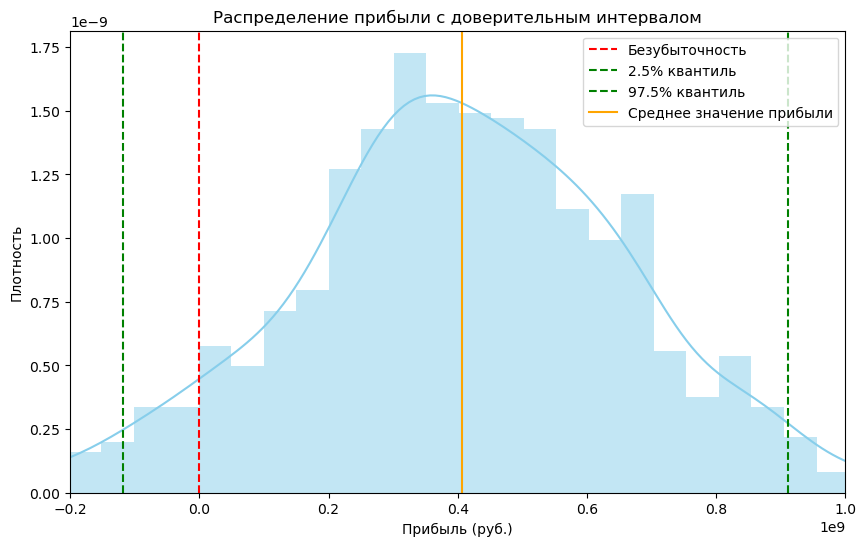

In [172]:
print('Регион 0')
bootstrap(y_0_pred,y_0_valid)

Регион 1
Среднее значение прибыли = 432.62 млн. руб.
95% доверительный интервал для прибыли (16.85 млн. руб. : 815.97 млн. руб.)
Вероятность убытков: 1.90 %


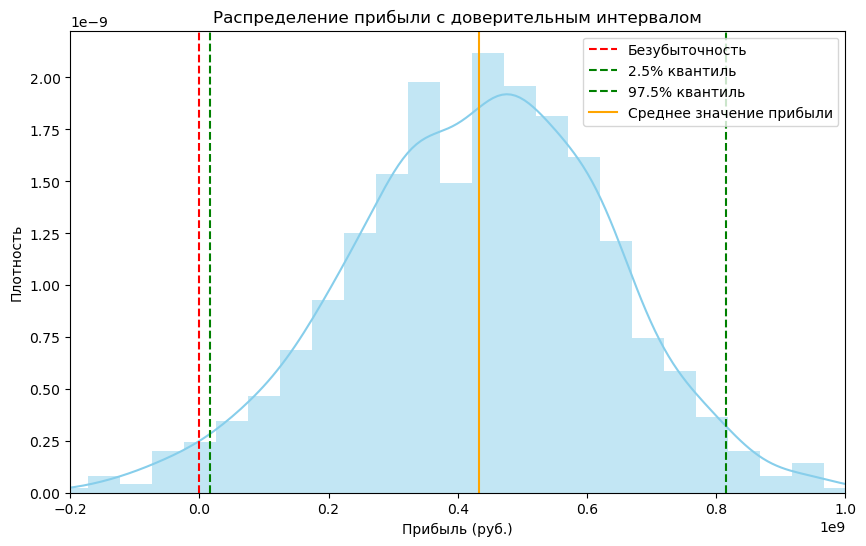

In [173]:
print('Регион 1')
bootstrap(y_1_pred,y_1_valid)

Регион 2
Среднее значение прибыли = 377.36 млн. руб.
95% доверительный интервал для прибыли (-170.78 млн. руб. : 901.77 млн. руб.)
Вероятность убытков: 7.40 %


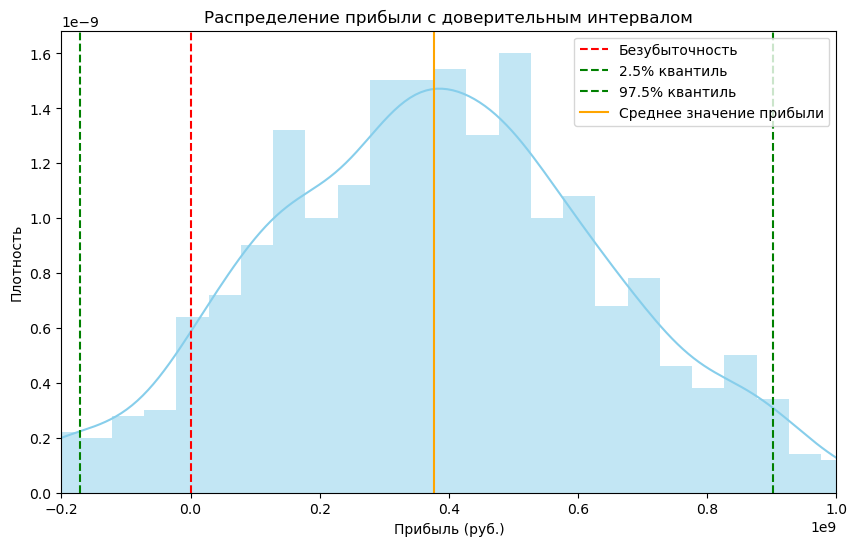

In [174]:
print('Регион 2')
bootstrap(y_2_pred,y_2_valid)

**Вывод**:

Наибольшая средняя прибыль отмечается в регионе под номером 1. Также в этом регионе наименьшая вероятность убытков — всего 1.9%, что полностью соответствует установленному требованию о не более 2,5% вероятности потерь. Остальные регионы (под номерами 0 и 2) характеризуются меньшей средней прибылью и более высокой вероятностью убытков.

Для разработки скважен предложен регион под номером 1.

## Общий вывод

1. **Загрузка данных и подготовка данных** 
    * Данные были загружены и предобработаны. Были устранены дубликаты.
    * Был проведен исследовательский и корреляционный анализ признаков таблиц. Данные были подготовлены для дальнейшего моделирования
 
    
2. **Обучение и проверка модели**

* Модель машинного обучения была обучена на данных трёх регионов

* В первом регионе зафиксировано самое низкое значение метрики RMSE

* Первый регион является наиболее точно предсказывается моделью
    
    
3. **Подготовка к расчету прибыли**
    
* Чтобы регион приносил прибыль, необходимо, чтобы средняя добыча с одной скважины составляла более 111,11 тысяч баррелей. Это значение превышает средние показатели по всем регионам, что подчеркивает важность неслучайного отбора скважин для достижения прибыли.
    
    
4. **Расчет прибыли и рисков**

* Наибольшая средняя прибыль наблюдается в регионе под номером 1. 
* В регионе 1 наблюдается наименьшая вероятность убытков — всего 1,9%, что соответствует установленному требованию о не более 2,5% вероятности потерь. 
* Регионы под номерами 0 и 2 имеют меньшую среднюю прибыль и более высокую вероятность убытков.

**Для разработки скважин предложен регион под номером 1.**

Характеристики выбранного региона:

Среднее значение прибыли: 432,62 млн руб.

95% доверительный интервал прибыли для региона 1: от 16,85 млн руб. до 815,97 млн руб.
